In [ ]:
!pip install prophet

In [10]:
import warnings;
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
import pickle as pkl
import torch
import prophet_model
from visual_files import visualization

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import time
import utils
import start_model
import train_functions
import models.gcn as gcn
import models.gru as gru
import models.tgcn as tgcn
import models.a3t_gcn as a3t_gcn
pd.options.display.max_columns = 100

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [12]:
adj_matrix, transactions_speed_days = utils.load_files('./data/distance_adj_matrix.csv'), utils.load_files('./data/time_series_data.csv')
time_series_long_sorted = utils.load_files_prophet('./data/prophet_time_series_data.csv')

print(f'Transaction Speed data shape: {transactions_speed_days.shape}')
print(f'Adjacency matrix shape: {adj_matrix.shape}')

Transaction Speed data shape: (365, 85)
Adjacency matrix shape: (85, 85)


In [13]:
time_series_long_sorted

,ds,atm,y
0,2017-01-01,0,68.0
1,2017-01-01,108,0.0
2,2017-01-01,105,0.0
3,2017-01-01,7,10.0
4,2017-01-01,86,0.0
...,...,...,...
31020,2017-12-31,36,56.0
31021,2017-12-31,64,62.0
31022,2017-12-31,47,74.0
31023,2017-12-31,10,74.0


## Settings

In [14]:
# Initial learning rate
learning_rate = 0.001

# Number of epochs to train
training_epoch = 10

# hidden units of gru
gru_units = 92

# time length of inputs
seq_len = 30                    #changed (was 7)

# time length of prediction
output_dim = pre_len = 30          #changed (was 7)

# rate of training set
train_rate = 0.92                  #changed (was 0.92)

# batch size
batch_size = 32

x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred = [],[],[],[],[],[],[]

## Train-Test Split

In [15]:
# Train Test Split for GCN, GRU, T-GCN, A3T-GCN
adj, data = adj_matrix, transactions_speed_days

time_len = data.shape[0]
num_nodes = data.shape[1]

data1 =np.mat(data,dtype=np.float32)
max_value = np.max(data1)
data1  = data1/max_value

trainX, trainY, testX, testY = utils.preprocess_data(data1, time_len, train_rate, seq_len, pre_len)

totalbatch = int(np.array(trainX).shape[0]/batch_size)
training_data_count = len(trainX)

# Train Test Split for Baseline
train_prophet = time_series_long_sorted.loc[time_series_long_sorted['ds'] < '2017-12-02']
valid_prophet = time_series_long_sorted.loc[(time_series_long_sorted['ds'] >= '2017-12-02')]

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 #'cuda:0' if torch.cuda.is_available() else
device

device(type='cuda', index=0)

## Start Model

#### GCN, GRU, TGCN, A3T-GCN

In [18]:
model_name = 'GRU'

In [19]:
y_pred, test_rmse, test_wmape = start_model.initialization(model_name, trainX, trainY, testX, testY, adj, learning_rate, gru_units, seq_len, pre_len, training_epoch, totalbatch, batch_size, num_nodes, device)

Number of weights: 25944
Iter: 1 mae: 0.03164 rmse: 0.038 mape: inf wmape_score: 0.6328
Iter: 2 mae: 0.02481 rmse: 0.03036 mape: inf wmape_score: 0.4962
Iter: 3 mae: 0.02452 rmse: 0.03009 mape: inf wmape_score: 0.4904
Iter: 4 mae: 0.0234 rmse: 0.02896 mape: inf wmape_score: 0.4682
Iter: 5 mae: 0.02235 rmse: 0.02797 mape: inf wmape_score: 0.4471
Iter: 6 mae: 0.022 rmse: 0.02762 mape: inf wmape_score: 0.44
Iter: 7 mae: 0.02213 rmse: 0.02761 mape: inf wmape_score: 0.4426
Iter: 8 mae: 0.0219 rmse: 0.02735 mape: inf wmape_score: 0.438
Iter: 9 mae: 0.022 rmse: 0.0274 mape: inf wmape_score: 0.44
Iter: 10 mae: 0.02179 rmse: 0.0272 mape: inf wmape_score: 0.4359


#### Baseline: Prophet

In [20]:
p = prophet_model.prophet_run(train_prophet, valid_prophet)

atm: 0


21:37:58 - cmdstanpy - INFO - Chain [1] start processing
21:37:58 - cmdstanpy - INFO - Chain [1] done processing


atm: 108


21:37:58 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing


atm: 105


21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing


atm: 7


21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing


atm: 86


21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing


atm: 18


21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing


atm: 19


21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing


atm: 64


21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing


atm: 38


21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing


atm: 90


21:38:02 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing


atm: 83


21:38:02 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing


atm: 24


21:38:03 - cmdstanpy - INFO - Chain [1] start processing
21:38:03 - cmdstanpy - INFO - Chain [1] done processing


atm: 78


21:38:03 - cmdstanpy - INFO - Chain [1] start processing
21:38:03 - cmdstanpy - INFO - Chain [1] done processing


atm: 69


21:38:03 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing


atm: 33


21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing


atm: 102


21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing


atm: 36


21:38:05 - cmdstanpy - INFO - Chain [1] start processing
21:38:05 - cmdstanpy - INFO - Chain [1] done processing
21:38:05 - cmdstanpy - INFO - Chain [1] start processing


atm: 35


21:38:05 - cmdstanpy - INFO - Chain [1] done processing


atm: 67


21:38:05 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing


atm: 109


21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing


atm: 46


21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing


atm: 56


21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing


atm: 3


21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing


atm: 32


21:38:08 - cmdstanpy - INFO - Chain [1] start processing
21:38:08 - cmdstanpy - INFO - Chain [1] done processing


atm: 4


21:38:08 - cmdstanpy - INFO - Chain [1] start processing
21:38:08 - cmdstanpy - INFO - Chain [1] done processing


atm: 70


21:38:08 - cmdstanpy - INFO - Chain [1] start processing
21:38:08 - cmdstanpy - INFO - Chain [1] done processing


atm: 107


21:38:09 - cmdstanpy - INFO - Chain [1] start processing
21:38:09 - cmdstanpy - INFO - Chain [1] done processing
21:38:09 - cmdstanpy - INFO - Chain [1] start processing


atm: 74


21:38:09 - cmdstanpy - INFO - Chain [1] done processing


atm: 66


21:38:10 - cmdstanpy - INFO - Chain [1] start processing
21:38:10 - cmdstanpy - INFO - Chain [1] done processing


atm: 99


21:38:10 - cmdstanpy - INFO - Chain [1] start processing
21:38:10 - cmdstanpy - INFO - Chain [1] done processing


atm: 103


21:38:10 - cmdstanpy - INFO - Chain [1] start processing
21:38:10 - cmdstanpy - INFO - Chain [1] done processing


atm: 14


21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing


atm: 91


21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing


atm: 17


21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing


atm: 50


21:38:12 - cmdstanpy - INFO - Chain [1] done processing


atm: 52


21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:12 - cmdstanpy - INFO - Chain [1] done processing


atm: 9


21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing


atm: 82


21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing


atm: 25


21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing
21:38:14 - cmdstanpy - INFO - Chain [1] start processing


atm: 104


21:38:14 - cmdstanpy - INFO - Chain [1] done processing


atm: 8


21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing


atm: 77


21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing


atm: 22


21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing


atm: 106


21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:16 - cmdstanpy - INFO - Chain [1] done processing


atm: 6


21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:16 - cmdstanpy - INFO - Chain [1] done processing


atm: 42


21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing


atm: 60


21:38:17 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing


atm: 5


21:38:17 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing


atm: 21


21:38:18 - cmdstanpy - INFO - Chain [1] start processing
21:38:18 - cmdstanpy - INFO - Chain [1] done processing


atm: 27


21:38:18 - cmdstanpy - INFO - Chain [1] start processing
21:38:18 - cmdstanpy - INFO - Chain [1] done processing


atm: 75


21:38:19 - cmdstanpy - INFO - Chain [1] start processing
21:38:19 - cmdstanpy - INFO - Chain [1] done processing


atm: 30


21:38:19 - cmdstanpy - INFO - Chain [1] start processing
21:38:19 - cmdstanpy - INFO - Chain [1] done processing
21:38:19 - cmdstanpy - INFO - Chain [1] start processing


atm: 58


21:38:20 - cmdstanpy - INFO - Chain [1] done processing


atm: 10


21:38:20 - cmdstanpy - INFO - Chain [1] start processing
21:38:20 - cmdstanpy - INFO - Chain [1] done processing


atm: 48


21:38:20 - cmdstanpy - INFO - Chain [1] start processing
21:38:20 - cmdstanpy - INFO - Chain [1] done processing


atm: 59


21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing


atm: 84


21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing


atm: 55


21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing


atm: 54


21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing


atm: 34


21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing


atm: 43


21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing


atm: 62


21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing


atm: 40


21:38:24 - cmdstanpy - INFO - Chain [1] start processing
21:38:24 - cmdstanpy - INFO - Chain [1] done processing


atm: 65


21:38:24 - cmdstanpy - INFO - Chain [1] start processing
21:38:24 - cmdstanpy - INFO - Chain [1] done processing


atm: 41


21:38:25 - cmdstanpy - INFO - Chain [1] start processing
21:38:25 - cmdstanpy - INFO - Chain [1] done processing


atm: 61


21:38:25 - cmdstanpy - INFO - Chain [1] start processing
21:38:25 - cmdstanpy - INFO - Chain [1] done processing


atm: 31


21:38:26 - cmdstanpy - INFO - Chain [1] start processing
21:38:26 - cmdstanpy - INFO - Chain [1] done processing


atm: 71


21:38:26 - cmdstanpy - INFO - Chain [1] start processing
21:38:26 - cmdstanpy - INFO - Chain [1] done processing


atm: 44


21:38:27 - cmdstanpy - INFO - Chain [1] start processing
21:38:27 - cmdstanpy - INFO - Chain [1] done processing


atm: 47


21:38:27 - cmdstanpy - INFO - Chain [1] start processing
21:38:27 - cmdstanpy - INFO - Chain [1] done processing


atm: 45


21:38:27 - cmdstanpy - INFO - Chain [1] start processing
21:38:27 - cmdstanpy - INFO - Chain [1] done processing


atm: 68


21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing


atm: 79


21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing


atm: 57


21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:29 - cmdstanpy - INFO - Chain [1] done processing


atm: 76


21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:29 - cmdstanpy - INFO - Chain [1] done processing


atm: 26


21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing


atm: 23


21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing


atm: 37


21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] done processing


atm: 20


21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] done processing


atm: 98


21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] done processing


atm: 12


21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing


atm: 39


21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing


atm: 100


21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing


atm: 63


21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing


atm: 16


21:38:34 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] done processing


## Visualization

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

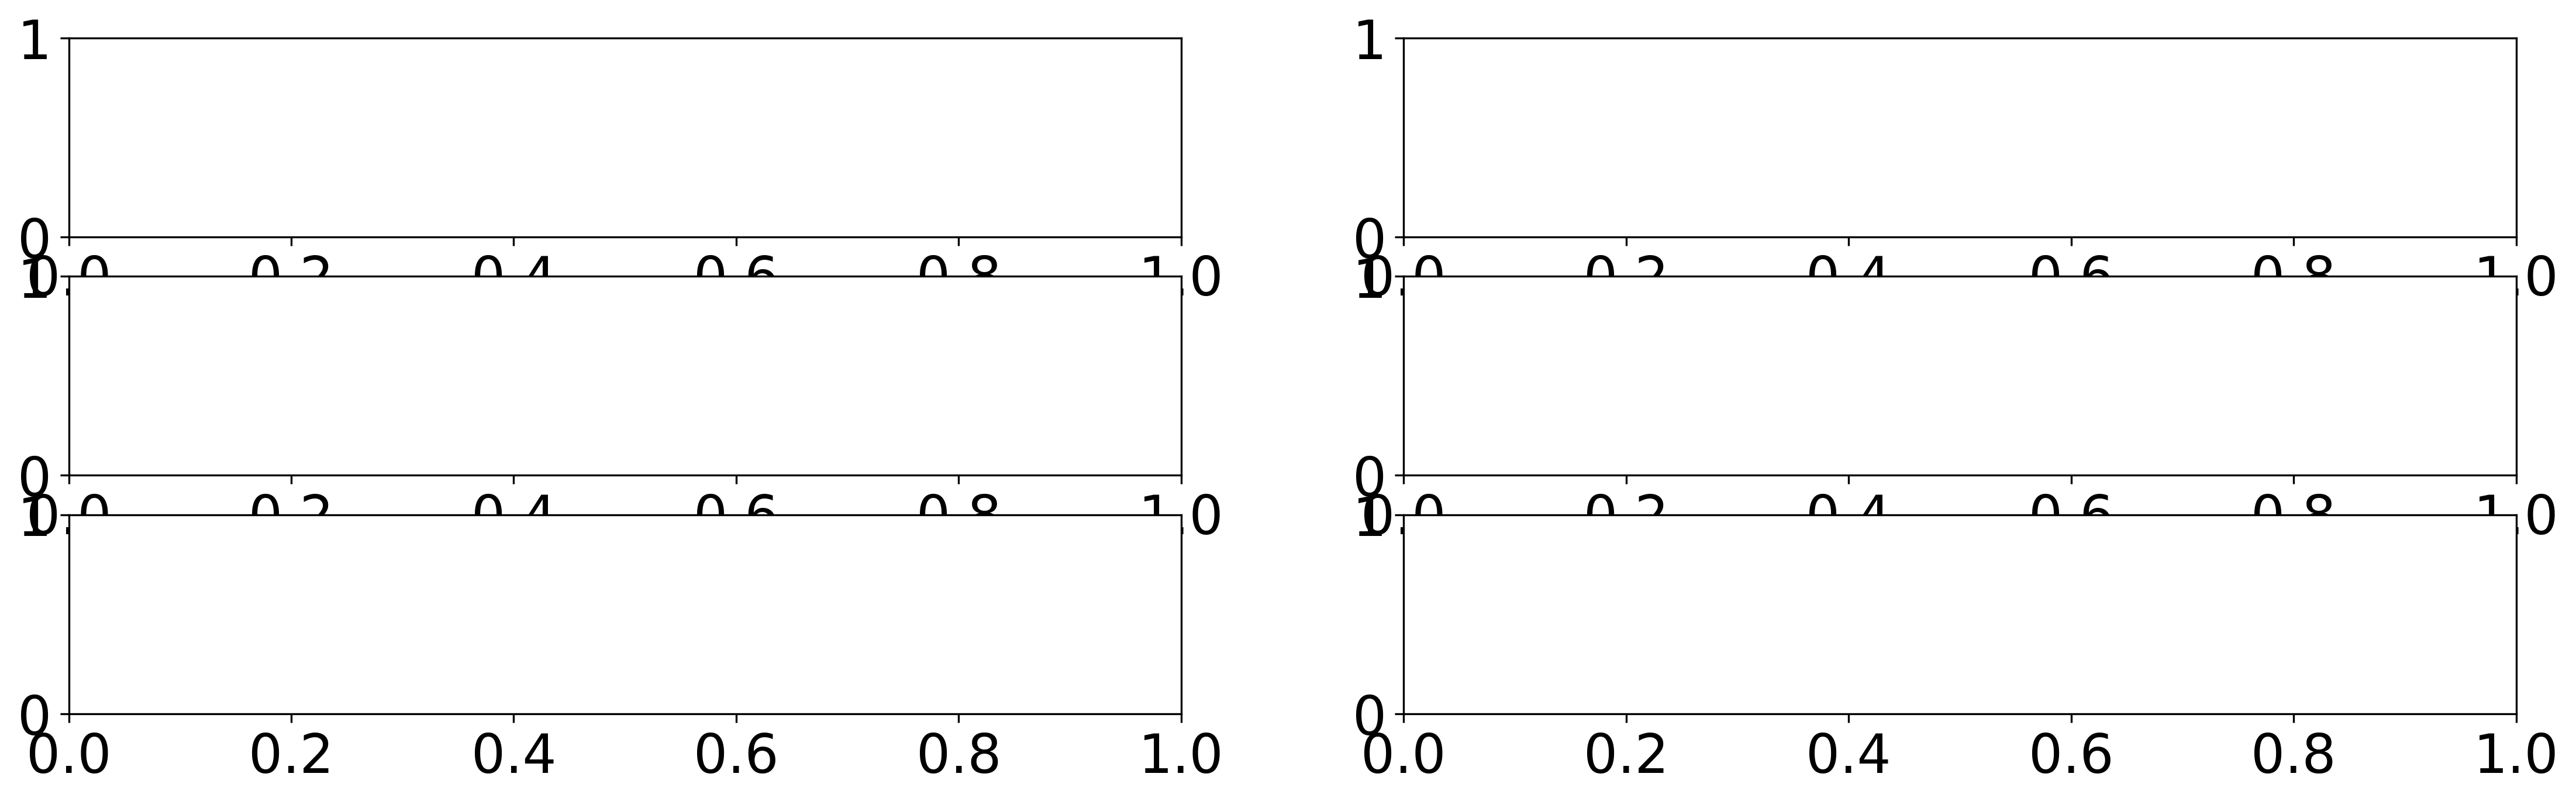

In [22]:
visualization.visualize(y_pred, train_prophet, p)